## SWEATER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import pywt
from numpy import fft
from scipy import signal
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

## Load the original data

In [2]:
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


## Select only the meaningful data

Al fine di selezionare un intervallo significativo dei dati raccolti, è stato eseguito un plot rappresentativo di AccX GyroX MagnX in funzione del tempo. Il tempo (in secondi) associato a ciascuna misura è stato derivato dalla frequenza di campionamento 'Log Freq' a 100Hz.

Come intervallo signoficativo si è, dunque, tenuto quello compreso tra [10,140] s, come mostrato in figura. A questo punto il tempo è stato riscalato, in modo che la prima misurazione significativa corrisponda a 0s.

Text(0, 0.5, 'Magnetic Field [mG?????]')

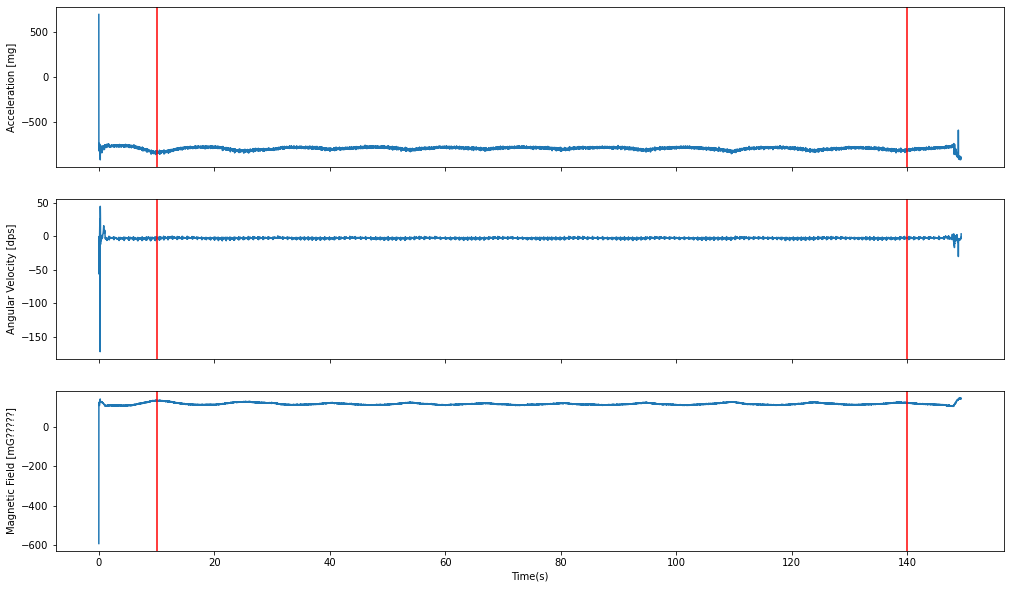

In [3]:
#raw data
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

t = np.arange(0, len(DF['AccX']))/DF['Log Freq'][0]
ax1.plot(t, DF['AccX'])
ax1.axvline(x = 10, color = 'red')
ax1.axvline(x = 140, color = 'red')
ax1.set_ylabel('Acceleration [mg]')

ax2.plot(t, DF['GyroX'])
ax2.axvline(x = 10, color = 'red')
ax2.axvline(x = 140, color = 'red')
ax2.set_ylabel('Angular Velocity [dps]')

ax3.plot(t, DF['MagnX'])
ax3.axvline(x = 10, color = 'red')
ax3.axvline(x = 140, color = 'red')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Magnetic Field [mG?????]') 


Le colonne di maggior interesse sono quelle contenenti le misurazioni fatte da Accelerometro(mg), Giroscopio(dps) e relativi tempi(s). 
####I dati di magnetometro e quaternioni sono stati scartati in quanto l'ampiezza del segnale non è sufficiente per proseguire nell'analisi, come si vede dal plot di 'MagnX' e 'qw'  in funzione del tempo, per un intervallo di 20s.#####

Text(0.5, 0, 'Time [s]')

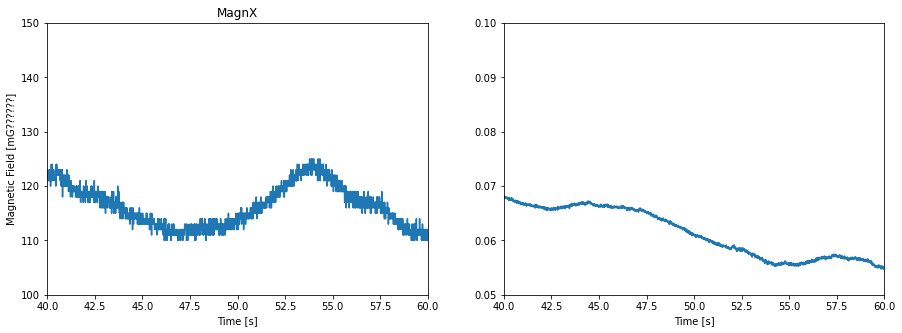

In [4]:
(fig, (ax1,ax2)) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(t,DF['MagnX'])
ax1.set_ylim(100,150)
ax1.set_xlim(40,60)
ax1.set_ylabel('Magnetic Field [mG??????]')
ax1.set_title('MagnX')
ax1.set_xlabel('Time [s]')

ax2.plot(t,DF['qw'])       ########
ax2.set_ylim(0.05,0.1)
ax2.set_xlim(40,60)
ax2.set_xlabel('Time [s]')

In [5]:
#new dataset
a = 1000
b = 14000
freq = DF['Log Freq'][0]
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1) #TOGLIERE MAGN???
df['Time'] = np.arange(0, len(df['AccX']))/freq
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-822.219,-105.957,579.012,-1.829268,0.609756,0.609756,132,56,-101,0.00
1001,-818.498,-111.386,577.731,-2.682927,0.731707,0.731707,133,57,-101,0.01
1002,-827.587,-108.214,577.670,-4.512195,0.609756,0.731707,134,57,-100,0.02
1003,-829.600,-110.105,570.594,-3.536585,1.463415,0.731707,135,56,-103,0.03
1004,-833.260,-108.824,563.701,-2.195122,1.341463,0.609756,133,56,-101,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-807.213,-78.019,617.259,-2.682927,0.609756,0.365854,123,45,-116,129.96
13997,-803.980,-72.041,616.344,-2.682927,1.219512,0.609756,122,46,-114,129.97
13998,-803.065,-78.934,597.068,-2.804878,1.097561,0.243902,122,45,-114,129.98
13999,-802.211,-79.788,614.697,-2.682927,1.829268,0.243902,122,45,-113,129.99


## Calibration
Di seguito è riportata la procedura di calibrazione eseguita sul dataset.

In [6]:
#calibration matrices and offset vectors
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])
magn_cal=np.array([[1.013437, -0.04728858, -0.001861475], 
                    [-0.04728862, 1.004832, 0.008222118],    
                    [-0.001861605, 0.008221965, 0.9439077]])
magn_off=np.array([-150.4098, 74.62431, 630.9805])

In [7]:
#calibration procedure
df[['GyroX','GyroY','GyroZ']]=df[['GyroX','GyroY','GyroZ']]+gyro_off.T
df[['AccX','AccY','AccZ']]=np.dot(df[['AccX','AccY','AccZ']],acc_cal.T)+acc_off.T
df[['MagnX','MagnY','MagnZ']]=np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T)+magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-818.561316,-128.123523,648.273377,-4.633667,2.402861,0.950927,-19.096268,123.822370,535.860520,0.00
1001,-814.835299,-133.565163,646.977212,-5.487326,2.524812,1.072878,-18.130119,124.779914,535.866881,0.01
1002,-823.951369,-130.385234,646.870258,-7.316594,2.402861,1.072878,-17.118544,124.740847,536.808927,0.02
1003,-826.001308,-132.271361,639.571807,-6.340984,3.256520,1.072878,-16.052234,123.664060,533.967120,0.03
1004,-829.702063,-130.977239,632.450211,-4.999521,3.134568,0.950927,-18.082831,123.775082,535.858659,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-803.341688,-100.163103,687.715099,-5.487326,2.402861,0.707024,-27.669104,113.071484,521.628218,129.96
13997,-800.102461,-94.167163,686.777527,-5.487326,3.012617,0.950927,-28.733553,114.140049,523.526117,129.97
13998,-799.269170,-101.051067,666.925868,-5.609277,2.890666,0.585073,-28.686264,113.135217,523.517895,129.98
13999,-798.336075,-101.932782,685.099032,-5.487326,3.622373,0.585073,-28.688125,113.143439,524.461803,129.99


## Statistical analysis:

Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [8]:
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-782.610405,-94.627886,707.983191,-5.620871,3.297117,0.622097,-33.587392,111.062144,512.477053
median,-780.100191,-94.335121,711.157509,-5.609277,3.256520,0.585073,-34.651833,111.255108,511.231737
variance,198.130373,180.768600,491.788827,0.641299,0.901328,0.056764,20.199608,18.519174,38.279886
standard deviation,14.075879,13.445021,22.176312,0.800812,0.949383,0.238252,4.494397,4.303391,6.187074
25% percentile,-791.461692,-103.978008,694.757991,-5.975131,2.646764,0.463122,-36.711103,107.461957,508.368212
75% percentile,-772.174827,-84.323690,723.607053,-5.121472,3.866276,0.828976,-30.709415,114.098938,515.965858


Correlation coefficients:

In [9]:
M = df.loc[:,:'MagnZ'].corr()  #Pearson   notare correlazioni >0.3
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,0.728544,0.721530,-0.039568,0.051239,0.009302,-0.852672,-0.730955,-0.856492
AccY,0.728544,1.000000,0.718113,-0.029258,0.045958,-0.029860,-0.856788,-0.936514,-0.694176
AccZ,0.721530,0.718113,1.000000,-0.034282,0.008241,-0.031668,-0.799319,-0.704363,-0.784541
GyroX,-0.039568,-0.029258,-0.034282,1.000000,-0.524570,0.489724,0.043550,0.054326,0.024516
GyroY,0.051239,0.045958,0.008241,-0.524570,1.000000,-0.548018,-0.063671,-0.060582,-0.048792
GyroZ,0.009302,-0.029860,-0.031668,0.489724,-0.548018,1.000000,0.020478,0.027613,0.001563
MagnX,-0.852672,-0.856788,-0.799319,0.043550,-0.063671,0.020478,1.000000,0.876702,0.911527
MagnY,-0.730955,-0.936514,-0.704363,0.054326,-0.060582,0.027613,0.876702,1.000000,0.725042
MagnZ,-0.856492,-0.694176,-0.784541,0.024516,-0.048792,0.001563,0.911527,0.725042,1.000000


## Centers Data

In [10]:
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
1000,-35.950911,-33.495636,-59.709814,0.987204,-0.894256,0.328830,14.491125,12.760226,23.383468,0.00
1001,-32.224895,-38.937276,-61.005979,0.133545,-0.772305,0.450781,15.457273,13.717769,23.389828,0.01
1002,-41.340965,-35.757348,-61.112933,-1.695723,-0.894256,0.450781,16.468849,13.678703,24.331874,0.02
1003,-43.390903,-37.643475,-68.411384,-0.720113,-0.040597,0.450781,17.535159,12.601916,21.490067,0.03
1004,-47.091659,-36.349353,-75.532980,0.621350,-0.162549,0.328830,15.504562,12.712937,23.381606,0.04
...,...,...,...,...,...,...,...,...,...,...
13996,-20.731283,-5.535217,-20.268092,0.133545,-0.894256,0.084928,5.918288,2.009340,9.151165,129.96
13997,-17.492057,0.460723,-21.205664,0.133545,-0.284500,0.328830,4.853840,3.077905,11.049064,129.97
13998,-16.658765,-6.423181,-41.057323,0.011594,-0.406451,-0.037023,4.901129,2.073073,11.040842,129.98
13999,-15.725670,-7.304895,-22.884159,0.133545,0.325256,-0.037023,4.899267,2.081295,11.984750,129.99


## PCA
Dal momento che le misurazioni di accelerazione e velocità angolare sono state fatte lungo i tre assi, si è applicata l'analisi PCA per stabilire quale di queste componenti portasse l'informazione maggiore.

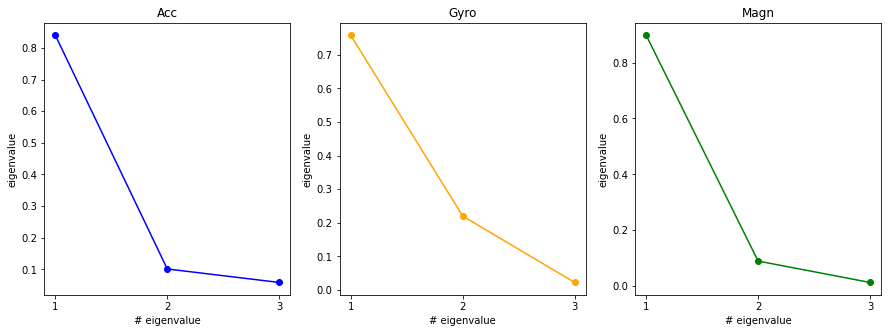

In [11]:
N = dfc.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfc[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfc[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfc[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = 'blue', marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = 'orange', marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = 'green', marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

I dati sono stati ruotati nel nuovo sistema di riferimento:

In [12]:
#rotation
rot = np.dot(dfc[['AccX','AccY','AccZ']],U_acc)
rot1 = np.dot(dfc[['GyroX','GyroY','GyroZ']],U_gyro)
rot2 = np.dot(dfc[['MagnX','MagnY','MagnZ']],U_magn)
dfr = pd.DataFrame({'Acc1': rot[:,0], 'Acc2': rot[:,1],'Acc3': rot[:,2],
                    'Gyro1': rot1[:,0], 'Gyro2': rot1[:,1],'Gyro3': rot1[:,2],
                    'Magn1': rot2[:,0], 'Magn2': rot2[:,1],'Magn3': rot2[:,2]})
dfr['Time']=dfc['Time'].values
dfr

,Acc1,Acc2,Acc3,Gyro1,Gyro2,Gyro3,Magn1,Magn2,Magn3,Time
0,77.287233,-2.507985,-0.285016,-1.335900,-0.274420,0.149860,-30.228499,1.929195,1.455566,0.00
1,78.944173,-2.311280,6.225786,-0.757095,0.342773,0.356100,-31.176755,1.038458,1.058361,0.01
2,81.736447,-6.054412,-2.225147,0.210685,1.893214,0.499728,-32.371076,1.486182,0.524131,0.02
3,89.218377,-3.810653,-2.340794,0.326879,0.602079,0.504049,-30.407488,0.459231,-1.812972,0.03
4,95.958489,-1.012308,-5.922360,-0.536077,-0.409420,0.256171,-30.742025,1.814292,0.588166,0.04
...,...,...,...,...,...,...,...,...,...,...
12996,27.568386,-2.929290,-10.130334,-0.806151,0.417733,-0.018994,-10.612818,3.058089,-0.907519,129.96
12997,24.361317,2.695078,-12.455011,-0.349711,0.056676,0.285295,-11.895611,3.522412,1.096414,129.97
12998,42.606398,11.725767,-7.188652,-0.327730,0.230213,-0.079389,-11.460882,4.298246,0.626219,129.98
12999,28.164233,0.744890,-5.528476,0.187943,-0.299094,-0.014716,-12.141677,4.860874,0.959388,129.99


Text(0.5, 0, 'Time(s)')

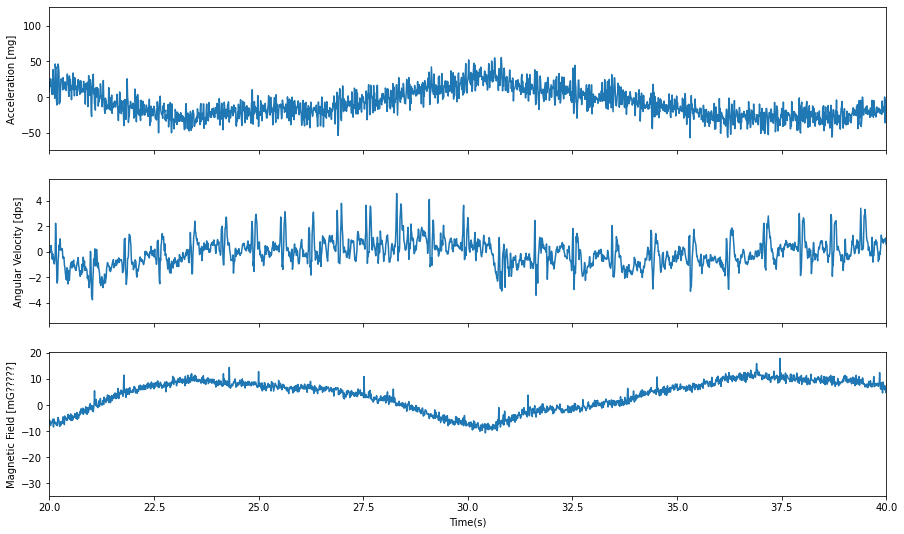

In [13]:
#principal components plots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,9),sharex=True)
ax[0].plot(dfr['Time'],dfr['Acc1'])
ax[0].set_ylabel('Acceleration [mg]')
ax[1].plot(dfr['Time'],dfr['Gyro1'])
ax[1].set_ylabel('Angular Velocity [dps]')
ax[2].plot(dfr['Time'],dfr['Magn1'])
ax[2].set_ylabel('Magnetic Field [mG?????]')

ax[2].set_xlim(20,40)
ax[2].set_xlabel('Time(s)')


## FFT analysis
Per ciascuna componente principale è stata calcolata la FFT per evidenziare la frequenza cardiaca nello spettro, tra 40BPM e 100BPM.

Text(0.5, 0, 'Frequencies [Hz]')

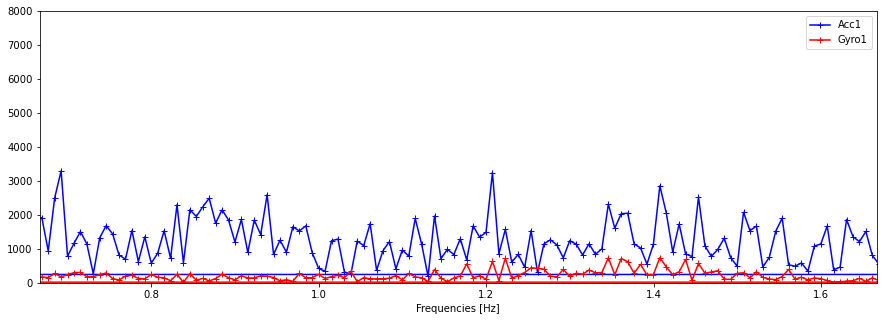

In [14]:
#select heart-beat freq
min_f=40./60.
max_f=100./60.

A1_FFT = np.abs(np.fft.fft(dfr['Acc1']))#-np.mean(dfr['Acc1'])))
G1_FFT = np.abs(np.fft.fft(dfr['Gyro1']))#-np.mean(dfr['Gyro1'])))

freq_FFT = np.fft.fftfreq(d=1/freq, n=len(A1_FFT))

X=[]
YA=[]
YG=[]
for i in range(len(A1_FFT)):
    if freq_FFT[i]<=max_f and freq_FFT[i]>=min_f:
        X.append(freq_FFT[i])
        YA.append(A1_FFT[i])
        YG.append(G1_FFT[i])
        
peakA,_ = signal.find_peaks(YA, height=4000)
peakG,_ = signal.find_peaks(YG, height=1500)
#print(X[peakA[0]])
#print(X[peakG[0]])

plt.figure(figsize = (15,5))
plt.plot(freq_FFT, A1_FFT,'b-+', label='Acc1')
plt.plot(freq_FFT, G1_FFT,'r-+', label='Gyro1')
#plt.axvline(x = X[peakA[0]])
#plt.axvline(x = X[peakG[0]], color='k', label='peak')
plt.xlim(min_f, max_f)
plt.ylim(0,8000)
plt.legend(loc='best')
plt.xlabel('Frequencies [Hz]')

## SIGNAL FILTERING
Il segnale è stato pulito con una serie di filtri, in modo da evidenziare il battito cardiaco.

- wavelet transform
- Hilbert envelop
- Butterworth filter (40-200)BPM

In [15]:
x = dfc['GyroX']  #centered data
y = dfc['GyroY']  #centered data
z = dfc['GyroZ']  #centered data
g = dfr['Gyro1']  #centered and rotated data (after PCA)
m = dfr['Magn1']  #centered and rotated data (after PCA)

sigA = dfr['Acc1']
sigG = dfr['Gyro1']
sigM = dfr['Magn1']
t = dfr['Time']

In [17]:
#plt.plot(t, a)

In [18]:
fg = fft.rfft(g, n = 10000)
freq = fft.rfftfreq(d=1/sample_f, n = 10000)
power= np.abs(fg)
plt.plot(freq, power)


NameError: name 'sample_f' is not defined

In [ ]:
peak_freq = freq[power.argmax()]
print("Principal frequency: ", peak_freq)

In [ ]:
fa_filt =  fa.copy()
fa_filt[(freq < 1) | (freq > 20)] = 0
a_filt = fft.irfft(fa_filt, a.size)

fig, ax = plt.subplots(figsize = (6,5))
ax.plot(t, a)
ax.plot(t, a_filt, color = 'orange')
plt.xlim(60, 70)

## Accelerometer

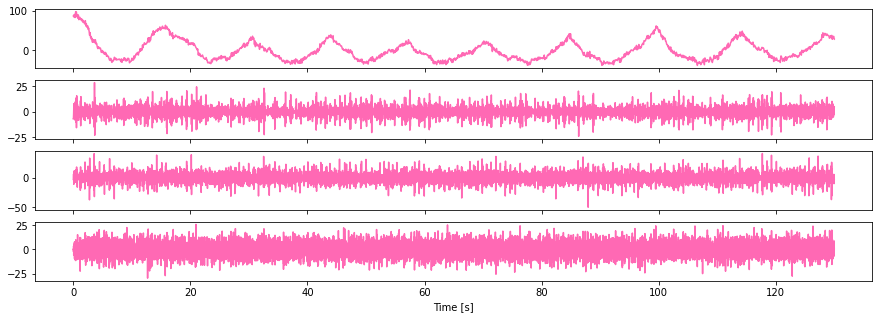

In [99]:
# WAVELET ACC
n = 3
cA = pywt.wavedec(sigA, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cA.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'hotpink')

Text(0.5, 0, 'Time [s]')

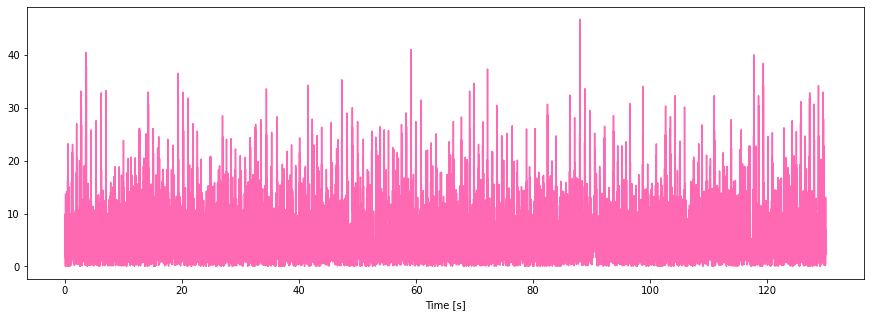

In [100]:
ca = cA.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigA_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigA_w[:-1]), color = 'hotpink')
plt.xlabel('Time [s]')

(30.0, 60.0)

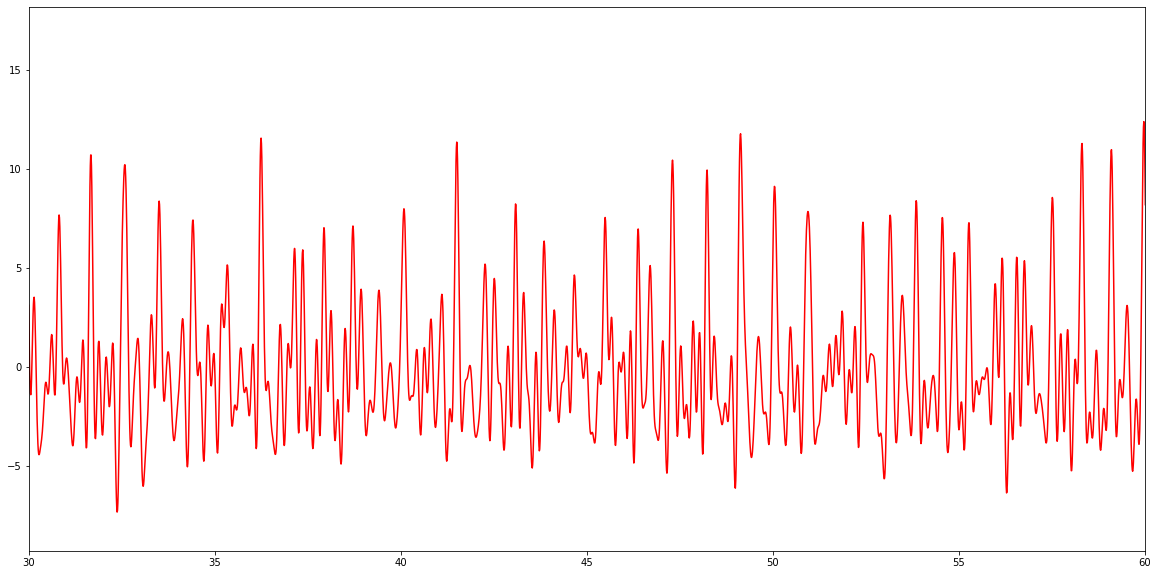

In [110]:
def FILTER(SIG,f1,f2):
    FFT = fft.rfft(SIG-SIG.mean())
    freq = fft.rfftfreq(len(SIG), 1/100)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = fft.irfft(new_FFT, len(SIG))
    return new_SIG

f1 = 0.66
f2 = 6
SIG = np.abs(sigA_w[:-1])
SIG_h = np.abs(signal.hilbert(SIG))

FILTER_A=FILTER(SIG,f1,f2)
plt.figure(figsize=(20,10))
plt.plot(t, FILTER_A, 'r')
#plt.plot(t, FILTER(SIG_h,f1,f2), 'b')
plt.xlim(30, 60)

Text(0.5, 0, 'Time [s]')

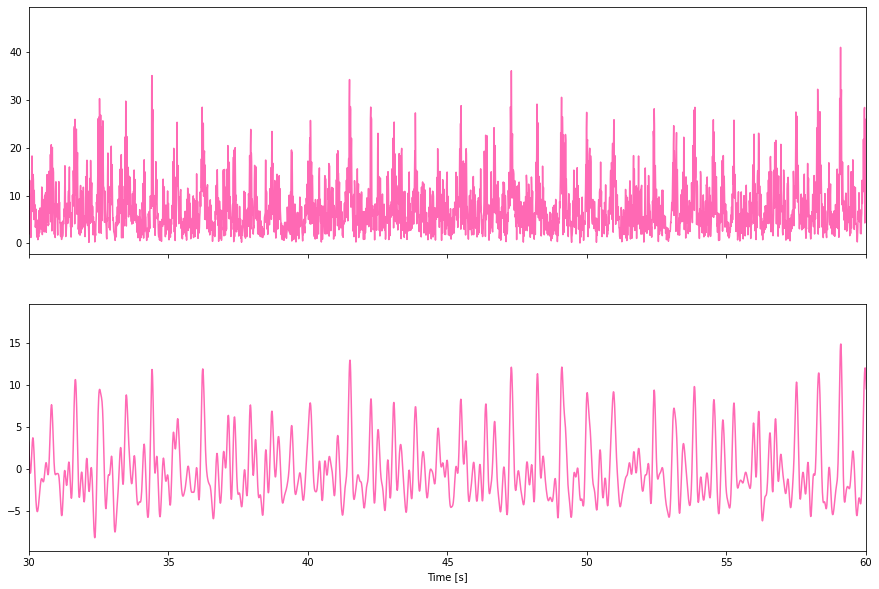

In [53]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigA_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'hotpink')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/50, 6/50], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'hotpink')
ax2.set_xlim(30,60)
ax2.set_xlabel('Time [s]')

## Gyroscope

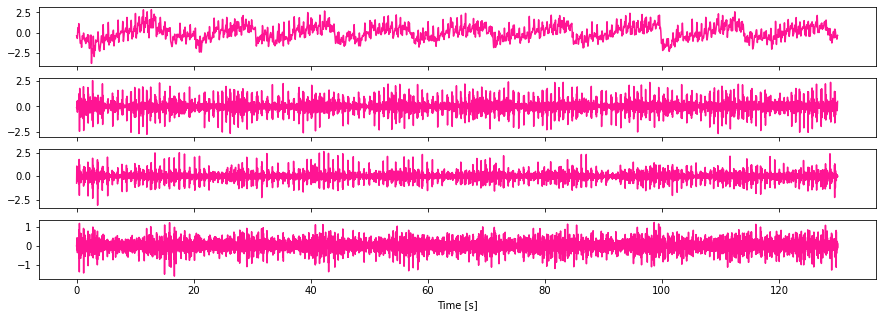

In [74]:
# WAVELET GYRO
n = 3
cG = pywt.wavedec(sigG, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cG.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'deeppink')

Text(0.5, 0, 'Time [s]')

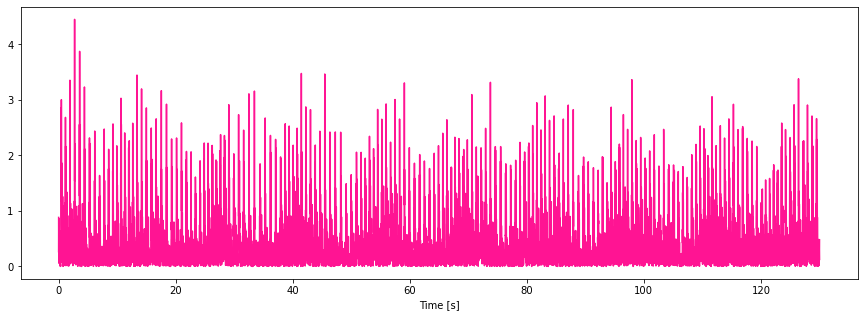

In [75]:
ca = cG.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigG_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigG_w[:-1]), color = 'deeppink')
plt.xlabel('Time [s]')

(30.0, 60.0)

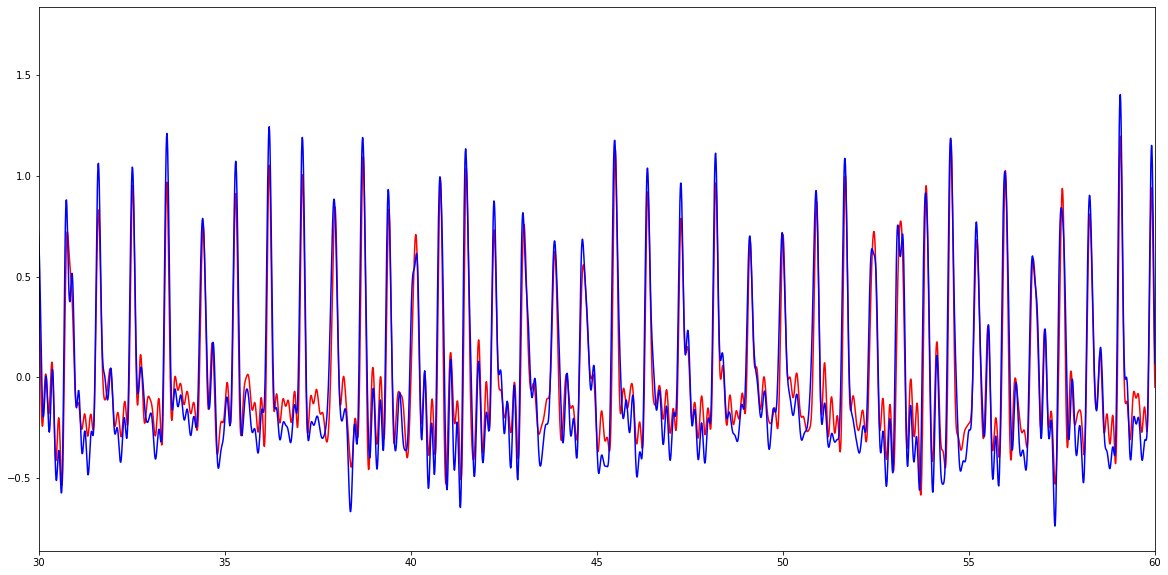

In [76]:
def FILTER(SIG,f1,f2):
    FFT = fft.rfft(SIG-SIG.mean())
    freq = fft.rfftfreq(len(SIG), 1/100)
    filt = np.zeros_like(freq)
    filt[(freq>f1) & (freq<f2)] = 1
    for i in range(len(freq)):
        if freq[i] > f1:
            filt[i-1] = 2/3
            filt[i-2] = 1/3
            break
    for i in range(len(freq)):
        if freq[i] > f2:
            filt[i] = 2/3
            filt[i+1] = 1/3
            break
    new_FFT = FFT*filt
    new_SIG = fft.irfft(new_FFT, len(SIG))
    return new_SIG

f1 = 0.66
f2 = 6
SIG = np.abs(sigG_w[:-1])
SIG_h = np.abs(signal.hilbert(SIG))

FILTER_G=FILTER(SIG,f1,f2)
plt.figure(figsize=(20,10))
plt.plot(t, FILTER_G, 'r')
plt.plot(t, FILTER(SIG_h,f1,f2), 'b')
plt.xlim(30, 60)

Text(0.5, 0, 'Time [s]')

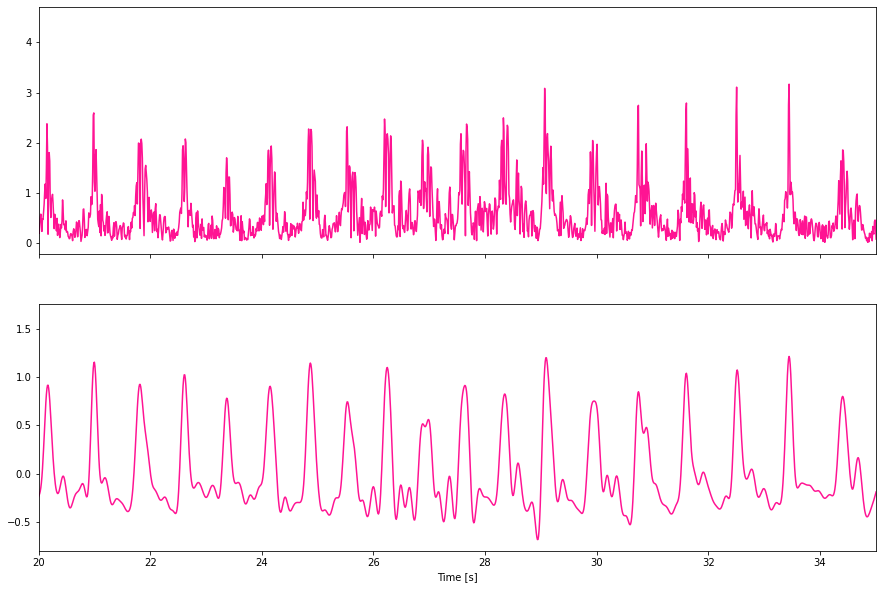

In [32]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigG_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'deeppink')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/50, 6/50], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'deeppink')
ax2.set_xlim(20, 35)
ax2.set_xlabel('Time [s]')

## Magnetometer

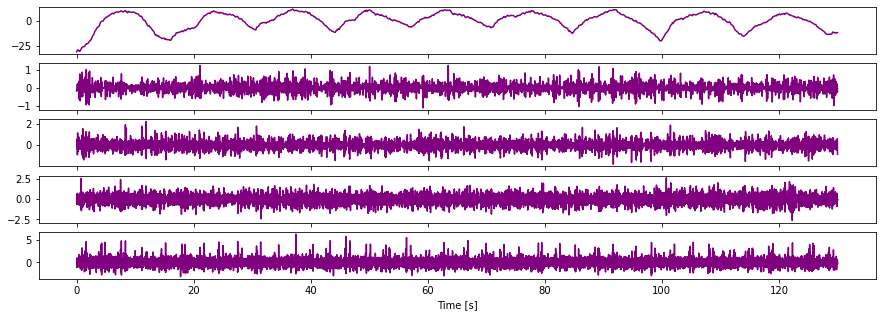

In [38]:
# WAVELET MAGN
n = 4
cM = pywt.wavedec(sigM, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = cM.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (15, 5), sharex=True)
ax[n].set_xlabel('Time [s]')
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'purple')

Text(0.5, 0, 'Time [s]')

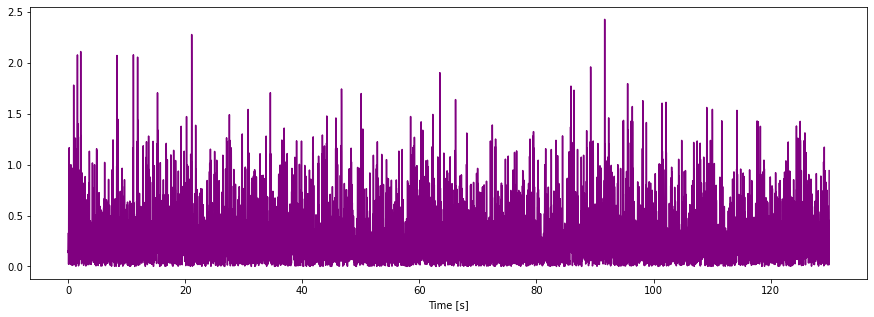

In [39]:
ca = cM.copy()
for j in range(n+1):
    if (j!=2) & (j!=1): 
        ca[j] = np.zeros_like(ca[j])
sigM_w = pywt.waverec(ca, 'bior5.5')

plt.figure(figsize=(15,5))
plt.plot(t, np.abs(sigM_w[:-1]), color = 'purple')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

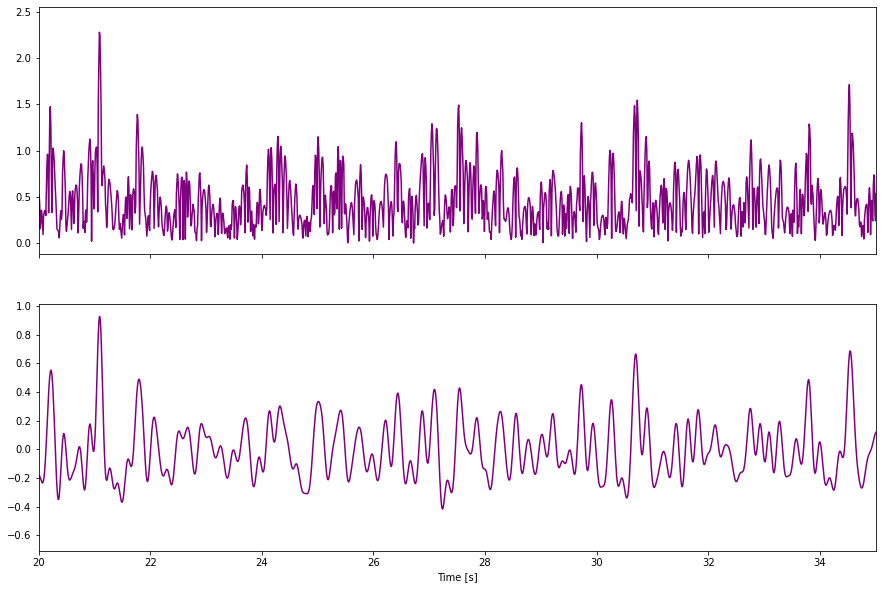

In [40]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10), sharex=True)

# Hilbert
SIG = np.abs(sigM_w[:-1])
SIG_h = signal.hilbert(SIG)
#ax1.plot(t, SIG[:])
ax1.plot(t, np.abs(SIG_h[:]), color = 'purple')

# Butterworth
b, a = signal.butter(4, Wn=[0.67/50, 6/50], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG_h))
ax2.plot(t, filtered_data_butterworth[:], color = 'purple')
ax2.set_xlim(20, 35)
ax2.set_xlabel('Time [s]')

## FIND PEAKS

In [77]:
def histo_func(bins1,peaks1,t):
    from matplotlib.gridspec import GridSpec
    #from lmfit.models import GaussianModel
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,'r-o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal', color='red')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

    #mod1 = GaussianModel(prefix='g_')
    #pars1 = mod1.guess(h1, x=bin_center1)
    #out1 = mod1.fit(h1, pars1, x=bin_center1)
    #print(out.params)
    #ax_marg.plot(out.best_fit, bin_center, 'r-', label='best fit')
    #print(out1.params['g_center'].value, out1.params['g_center'].stderr)
    #print(out1.params['g_sigma'].value, out1.params['g_sigma'].stderr)


In [78]:
data = FILTER_G

(50.0, 60.0)

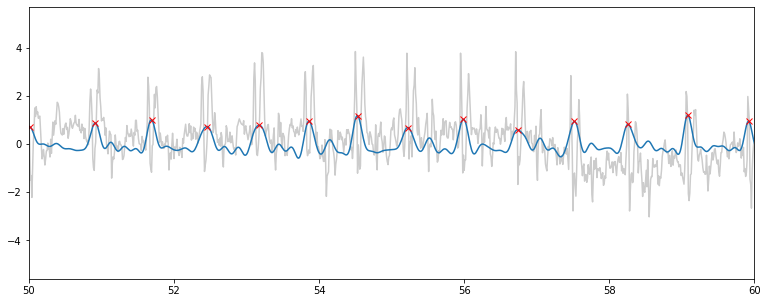

In [85]:
%matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(t,dfr['Gyro1'], color='grey',alpha=0.4)
plt.plot(t,data)
peaks1,_ = signal.find_peaks(data, height=0.3 , distance=50,threshold=None, prominence=None)
#print(peaks)
plt.plot(t[peaks1],data[peaks1], 'rx')
#plt.ylim(-20,40)
#peaks2,_=signal.find_peaks(-data, height=6, distance=55)
#plt.plot(t[peaks2],data[peaks2], 'gx')
plt.xlim(50,60)

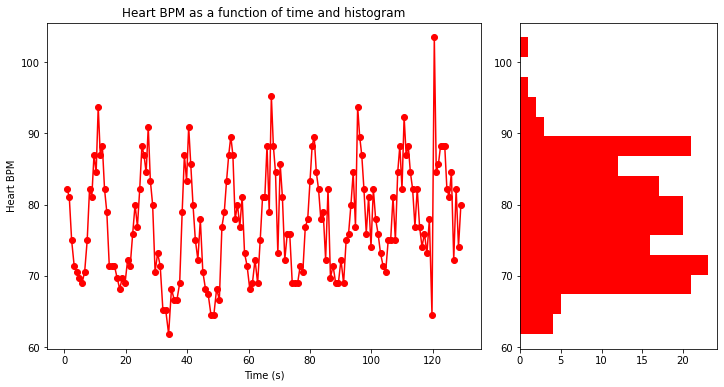

In [84]:
histo_func(15,peaks1,t.values)

In [111]:
data = FILTER_A

(90.0, 110.0)

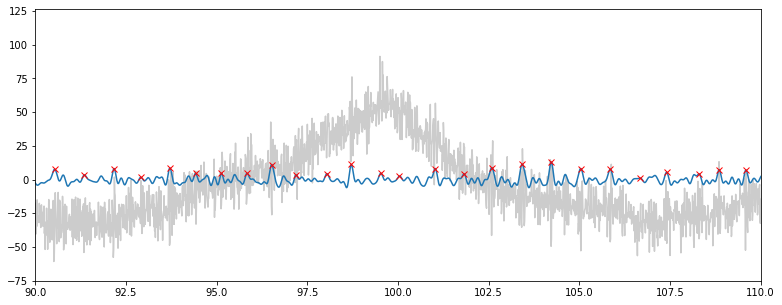

In [112]:
%matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(t,dfr['Acc1'], color='grey',alpha=0.4)
plt.plot(t,data)
peaks1,_ = signal.find_peaks(data, height=0.3 , distance=50,threshold=None, prominence=None)
#print(peaks)
plt.plot(t[peaks1],data[peaks1], 'rx')
#plt.ylim(-20,40)
#peaks2,_=signal.find_peaks(-data, height=6, distance=55)
#plt.plot(t[peaks2],data[peaks2], 'gx')
plt.xlim(90,110)

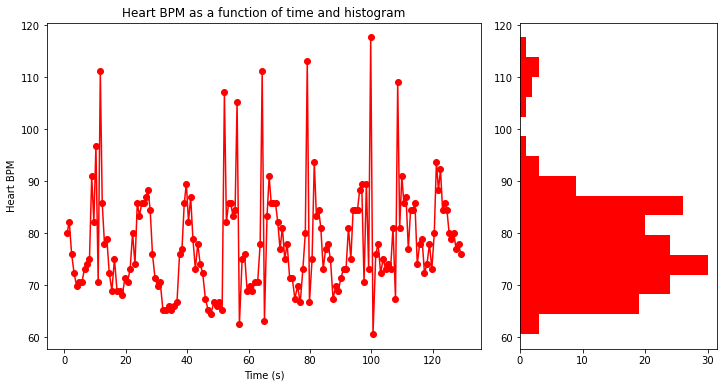

In [113]:
histo_func(15,peaks1,t.values)

In [114]:
#AGGIUSTA PICCHI ALESSANDRA
def fix2(time,peaks,data,thr,r=0.5):
    
    peaks_time=time[peaks]
    period = peaks_time[1:]-peaks_time[:-1]
    rate = 1/period*60
    
    peaks_new=peaks.copy()
    diff_mean=np.mean(np.abs(period[1:]-period[:-1]))
    for i in np.arange(1,len(period)-1):
        
        if np.abs(period[i]-period[i+1])>2*(diff_mean):
            new_thr=0.33*(thr+data[peaks[i+1]])
            if period[i]-period[i+1]>0:
                array=data[(time<time[peaks[i+1]]) & (time>time[peaks[i+1]]-r)]
                der = array[1:]-array[:-1]
                change=[]
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks[i+1]-len(array)+change[-1]
                
            if period[i]-period[i+1]<0: #
                array=data[(time>time[peaks[i+1]]) & (time<time[peaks[i+1]]+r)]
                der = array[1:]-array[:-1]
                change=np.array([])
                for d in range(len(der)-1):
                    if der[d]>0 and der[d+1]<0 and array[d+1]>new_thr: change=np.append(change,d+1)
                if len(change)>0:
                    peaks_new[i+1]= peaks[i+1] + change[0] +1
                
    plt.figure(figsize=(10,4))
    plt.plot(time,data)
    #plt.plot(time,high_sign,color='grey',alpha=0.5)
    plt.plot(time[peaks],data[peaks], 'rx', label='old peaks')
    plt.plot(time[peaks_new],data[peaks_new], 'gx', label='new peaks')
    plt.legend()
    return peaks_new

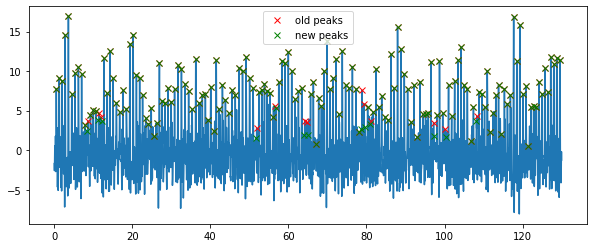

In [120]:
peaks_new = fix2(t.values,peaks1,data,0,r=0.3)

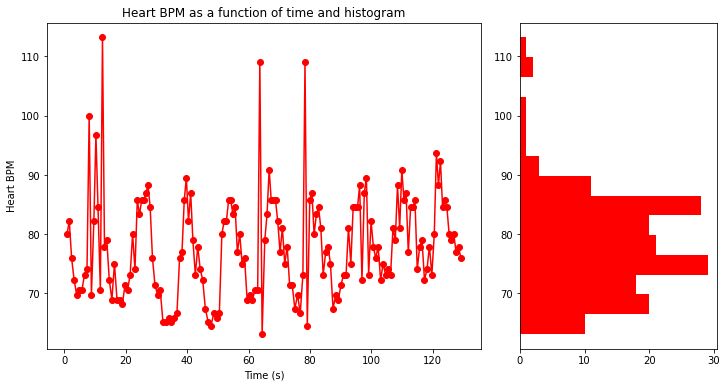

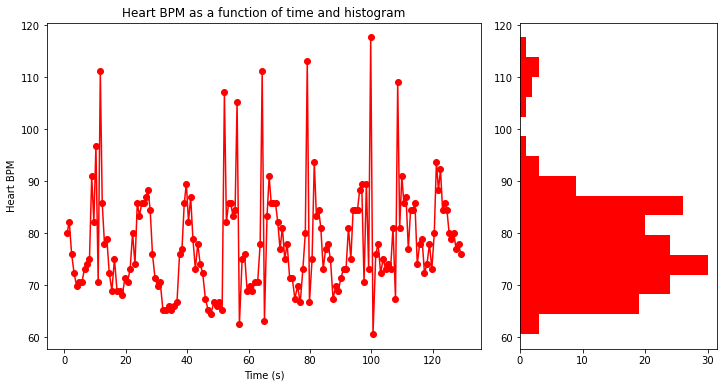

In [121]:
histo_func(15,peaks_new,t.values)
histo_func(15,peaks1,t.values)

(50.0, 60.0)

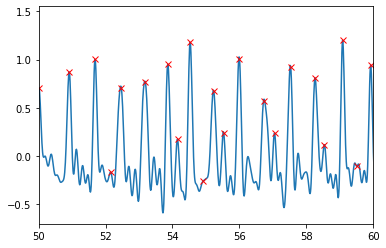

In [91]:
# FIND PEAKS WITH CWT
peaks_G_cwt = signal.find_peaks_cwt(FILTER_G, np.arange(1,30))
plt.plot(t,FILTER_G)
plt.plot(t[peaks_G_cwt],FILTER_G[peaks_G_cwt], 'rx')

plt.xlim(50,60)

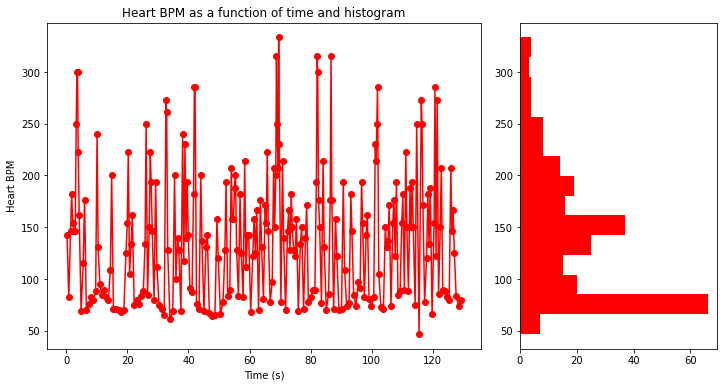

In [92]:
histo_func(15,peaks_G_cwt,t.values)